# Machine learning in chemistry

## Atomistic simulation environment (ASE)

The ASE is a set of tools and Python modules for setting up, manipulating, running, visualizing and analyzing atomistic simulations. It is interfaced with many ab initio and MD codes through simple calculators.

More information and manual: https://wiki.fysik.dtu.dk/ase/

For example, it can read and process xyz coordinates. 

FYI: An xyz file contains the cartesian coordinates of the atomic positions of each atom in a molecular system.

Let's start with simple alanine:

```
 13
 
 C    -0.779297    -1.210972     1.994359
 C     0.000000     0.000000     1.460000
 C     1.403962     0.000000     2.015868
 O     2.161436    -0.947142     1.883370
 N    -0.000000    -0.000000    -0.000000
 O     1.837767     0.962613     2.627089
 H     0.423874    -0.764689    -0.525339
 H    -0.501722     0.920815     1.792226
 H    -1.802818    -1.214186     1.591378
 H    -0.834094    -1.175236     3.092412
 H    -0.285041    -2.146224     1.692672
 H     2.730544     0.787839     2.900774
 H    -0.872821     0.015235    -0.504000
```


In [103]:
#Installation of ase and qml libraries
# !pip install ase==3.21.1
# !pip install qml

In [2]:
import ase #ASE module and important functionalities
import ase.io as aio
from ase.visualize import view
import numpy as np  #The numpy package
import pandas as pd # The pandas data framework
import matplotlib.pyplot as plt # The plotting library
import sklearn as sklearn # General purpose ML framework for python
from qml.math import cho_solve #Cholesky decomposition from qml library
from qml.kernels import gaussian_kernel #Gaussian kernel from qml

In [3]:
# Read xyz for alanine 
alanine = aio.read('./data/alanine.xyz')
#ASE can also visualize molecules
ase.visualize.view(alanine, viewer='x3d')


Ase can easily print information about the position of the elements, atomic numbers, distances between elements, bond angles etc.

In [4]:
alanine.positions #ASE prints xyz coordinates

array([[-0.779297, -1.210972,  1.994359],
       [ 0.      ,  0.      ,  1.46    ],
       [ 1.403962,  0.      ,  2.015868],
       [ 2.161436, -0.947142,  1.88337 ],
       [-0.      , -0.      , -0.      ],
       [ 1.837767,  0.962613,  2.627089],
       [ 0.423874, -0.764689, -0.525339],
       [-0.501722,  0.920815,  1.792226],
       [-1.802818, -1.214186,  1.591378],
       [-0.834094, -1.175236,  3.092412],
       [-0.285041, -2.146224,  1.692672],
       [ 2.730544,  0.787839,  2.900774],
       [-0.872821,  0.015235, -0.504   ]])

In [5]:
alanine.get_atomic_numbers() #ASE prints atomic numbers

array([6, 6, 6, 8, 7, 8, 1, 1, 1, 1, 1, 1, 1])

## Molecular representations

ML techniques enables to learn the relationships between set of molecules and known target properies, e.g. atomization energies, HOMO, LUMO, electronic densities etc. If the model is trained smartly, it is later able to predict these properties for the molecule which are nor contained in the original set.

In theory, molecules for the training could be represented by any descriptior, for example xyz coordinates, SMILES, number of atoms etc. 

There are many representations designed for the ML. In this tutorial, we will discuss the most popular ones, namely The Coulomb matrix, Bag-of-bonds and SLATM. All these representations are part of a QML toolkit. http://www.qmlcode.org/index.html



### The Coulomb matrix (CM)

Rupp et al. (2012) Phys Rev Lett https://doi.org/10.1103/PhysRevLett.108.058301

In the CM, structure of the molecule is represented by so called Coulomb matrix **M**, which is defined as 


 $ M_{ij} = \begin{dcases}
        0.5~Z_I^{2.4} & \mathrm{for}~I = J \\
        \frac{Z_IZ_J}{||\mathbf{R}_I - \mathbf{R}_J||} & \mathrm{for}~I \neq J \\
    \end{dcases} $ 
   
where $Z_I$ is a nuclear charge of the atom $I$ in the molecule and $\mathbf{R}_I$ is the set of Cartesian coordinates. The off-diagonal elements therefore correspond to the Coulomb repulsion between atoms I and J, while diagonal elements encode a polynomial fit of atomic energies to nuclear charge.

For the alanine molecule defined above, CM representation has a form (only lower triangular matrix is printed):
```
36.8581052
23.43749732 36.8581052
14.41900445 23.84106728 36.8581052
16.24569179 20.02064702 39.34425504 73.51669472
17.0737     28.76712329 17.09687195 18.54755536 53.3587074
13.87153295 20.16502713 39.34424014 30.84545566 16.72901287 73.51669472
 2.12189506  2.76583189  2.12091545  2.68851906  6.86274675  2.07108902  0.5   
 2.77872448  5.45454693  2.81918672  2.45834253  3.37111687  3.22016937  0.33206726  0.5
 5.45454714  2.75540866  1.7365516   2.00805581  2.59850131  1.83219403  0.32206669  0.39868111  0.5
 5.45454509  2.75540842  2.18376512  2.47038225  2.05174476  2.31657765  0.25959446  0.40179166  0.55962536  0.5
 5.45454468  2.75540822  2.1816791   2.92912333  2.54711145  2.06254654  0.36933897  0.32506637  0.56054284  0.55870726  0.5
 1.44943531  1.88307272  3.3733594   3.82728952  1.72374841  8.42105169  0.22663376  0.29242635  0.19509088  0.24546229  0.22844397  0.5
 2.15468985  2.79165065  1.76671616  2.01055671  6.94444238  1.88308126  0.66079628  0.40062728  0.38441699  0.26395517  0.31874369  0.19930903  0.5       

```



This matrix can be implemented from scratch, for example:

In [6]:
import numpy as np
import sklearn
from sklearn import metrics

cm = 1 / sklearn.metrics.pairwise_distances(alanine.positions) 
cm *= alanine.get_atomic_numbers() * alanine.get_atomic_numbers()[:, np.newaxis]
cm[np.diag_indices_from(cm)] =  0.5 * alanine.get_atomic_numbers() ** 2.4
cm[np.tril_indices_from(cm)]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


array([36.8581052 , 23.43749732, 36.8581052 , 14.41900445, 23.84106728,
       36.8581052 , 16.24569179, 20.02064702, 39.34425504, 73.51669472,
       17.0737    , 28.76712329, 17.09687195, 18.54755536, 53.3587074 ,
       13.87153295, 20.16502713, 39.34424014, 30.84545566, 16.72901287,
       73.51669472,  2.12189506,  2.76583189,  2.12091545,  2.68851906,
        6.86274675,  2.07108902,  0.5       ,  2.77872448,  5.45454693,
        2.81918672,  2.45834253,  3.37111687,  3.22016937,  0.33206726,
        0.5       ,  5.45454714,  2.75540866,  1.7365516 ,  2.00805581,
        2.59850131,  1.83219403,  0.32206669,  0.39868111,  0.5       ,
        5.45454509,  2.75540842,  2.18376512,  2.47038225,  2.05174476,
        2.31657765,  0.25959446,  0.40179166,  0.55962536,  0.5       ,
        5.45454468,  2.75540822,  2.1816791 ,  2.92912333,  2.54711145,
        2.06254654,  0.36933897,  0.32506637,  0.56054284,  0.55870726,
        0.5       ,  1.44943531,  1.88307272,  3.3733594 ,  3.82

The same matrix could be easily generated by qml toolkit:

In [7]:
#Import of necessary libraries
import qml
import numpy as np

ALA = qml.Compound(xyz="./data/alanine.xyz") #Class Coumpound, part of qml
ALA.generate_coulomb_matrix(size=13, sorting = 'unsorted')

np.set_printoptions(linewidth=100)
print(ALA.representation)

[36.8581052  23.43749732 36.8581052  14.41900445 23.84106728 36.8581052  16.24569179 20.02064702
 39.34425504 73.51669472 17.0737     28.76712329 17.09687195 18.54755536 53.3587074  13.87153295
 20.16502713 39.34424014 30.84545566 16.72901287 73.51669472  2.12189506  2.76583189  2.12091545
  2.68851906  6.86274675  2.07108902  0.5         2.77872448  5.45454693  2.81918672  2.45834253
  3.37111687  3.22016937  0.33206726  0.5         5.45454714  2.75540866  1.7365516   2.00805581
  2.59850131  1.83219403  0.32206669  0.39868111  0.5         5.45454509  2.75540842  2.18376512
  2.47038225  2.05174476  2.31657765  0.25959446  0.40179166  0.55962536  0.5         5.45454468
  2.75540822  2.1816791   2.92912333  2.54711145  2.06254654  0.36933897  0.32506637  0.56054284
  0.55870726  0.5         1.44943531  1.88307272  3.3733594   3.82728952  1.72374841  8.42105169
  0.22663376  0.29242635  0.19509088  0.24546229  0.22844397  0.5         2.15468985  2.79165065
  1.76671616  2.01055671  6.94

### Bag-of-bonds (BoB)

Hansen et al. (2015) J. Phys. Chem. Lett. https://doi.org/10.1021/acs.jpclett.5b00831

Representation BoB contains the same information as CM, but the items of the matrix are group diffrently. 

For alanine:

<img src="./data/bob.png" alt="bob" width="700"/>

1) Used nuclear charges for each Coulomb matrix element, 2) Coulomb matrix entries for alanine sorted into bags, 3) the BoB vector -
obtained by concatenating the bags and adding zeros to allow for dealing with other molecules with larger bags.


In [8]:
ALA = qml.Compound(xyz="./data/alanine.xyz")
ALA.generate_bob(asize={"O":3, "N":2, "C":4, "H":8})
print(ALA.representation)


### The Spectrum of London and Axillrod-Teller-Muto potential (SLATM)

While the CM and BoB representation are very intuitive and easy to compute and implement, they have several drawbacks. They both suffer from permutational variance, meaning that permutation of atoms can generate different representations, even if this effect is attenuated by different sorting strategies. 

To overcome these inherent flaws of CM and BoB, a more sohpisticated representation named SLATM was developped. The Spectrum of London and Axillrod-Teller-Muto (SLATM) potential is a representation constructed using one-, two- and three-body potential expressions. The "one-body" terms represent how many atoms of each atomtype are in a  molecule. The two-body terms group all the London interactions between different atomtypes, and the three-body terms group all the ATM interactions.

All these terms are concatenated one after the other to create the SLATM representation of a molecule. This representation is permutationally invariant, as all different sortings of the atoms in a molecule generate the same representation. Most importantly, different systems can be compared effectively by evaluating the difference in each of the n-body terms in the representation. 

As an example, below you can see represented the different terms of the SLATM representation of a molecule.

Huang et al. (2020) Nat. Chem. https://www.nature.com/articles/s41557-020-0527-z

Faber et al. (2018) J. Chem. Phys.  https://aip.scitation.org/doi/pdf/10.1063/1.5020710

<img src="./data/slatm.png" alt="slatm" width="900"/>

Let's see now the full representation of Alanine

In [9]:
import qml.representations 
from qml.representations import get_slatm_mbtypes
from qml.representations import generate_slatm

#Read alanine coordinates
coordinates = ALA.coordinates

#Alanine nuclear charges
nuclear_charges = ALA.nuclear_charges

#Generate Many Body types
mbtypes = get_slatm_mbtypes([nuclear_charges])

#Create SLATM reprezentation
rep = generate_slatm(coordinates, nuclear_charges, mbtypes)

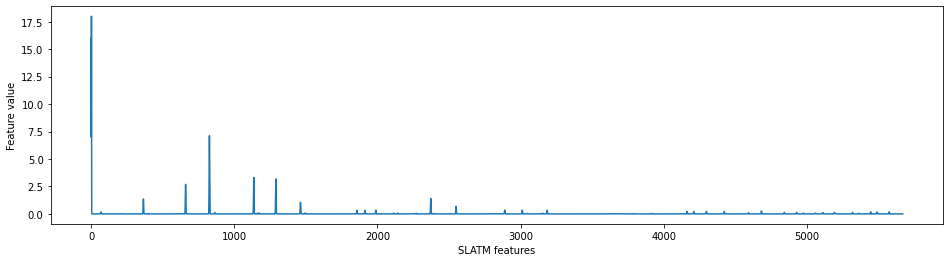

In [10]:
#Plot all the terms together
fig, ax = plt.subplots(figsize=[16,4])
ax.plot(rep)
ax.set_ylabel('Feature value')
ax.set_xlabel('SLATM features')
plt.show()

## Kernel Ridge Regression

The relations between the chemical properties of system and its structural information are often very complicated and can not be approximated by simple linear function. Therefore, more complex non-linear regression schemes are needed. 

KRR methods use so called kernel, which is a function describing the similarity between two points $x_i$ and $x_j$. Kernel functions are typically symmetric functions (i.e., $f(x,y) = f(y,x)$), for example various polynomials. In this tutorial, we use Gaussian kernel. It is defined as

$K(x_i, x_j) = \mathrm{exp}\left(-\frac{||x_i-x_j||^2}{2\sigma^2}\right).$

The target properties y are then represented as 

$\mathbf{y} = \mathbf{K \alpha}$,

where $\mathbf{K}$ is the  kernel fuction and $\alpha$ are regresion weigths. KRR with a Gaussian kernel is essentially the same as the SVR we used in the first tutorials.

In this tutorial, we are going to use KRR to predict internal energies at 0 K.

We will use part of QM9 database (Ruddigkeit et al. (2012) J. Chem. Inf. Mod https://pubs.acs.org/doi/abs/10.1021/ci300415d ,
Ramakrishnan et al. (2014) Scientific Data, https://www.nature.com/articles/sdata201422). This database is composed of molecules up to 9 heavy atoms (CHONF) an corresponding harmonic frequencies, dipole moments, polarizabilities, along with energies, enthalpies, and free energies of atomization. All properties were calculated at the B3LYP/6-31G(2df,p) level of theory.

In [11]:
# Import of libraries for data processing
import ase.io as aio
import pandas as pd

In [12]:
# Here we read properties in the qm9.csv using pandas library
qm9_data = pd.read_csv('./data/qm9/qm9.csv', index_col=0)

In [13]:
# You can see what is inside the file
qm9_data

,mol_id,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,157.71180,157.70997,157.70699,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
40,gdb_41,28.29567,4.14901,3.88349,1.0363,39.34,-0.2503,0.0925,0.3428,368.9331,0.107895,-194.254127,-194.248585,-194.247641,-194.281899,17.888,-1033.537443,-1040.724304,-1047.245378,-960.716279
80,gdb_81,7.57282,3.52550,2.65861,1.3149,49.26,-0.2629,0.0789,0.3418,516.4357,0.136209,-233.551389,-233.544542,-233.543598,-233.581067,23.924,-1315.881353,-1324.915600,-1333.215034,-1221.758140
120,gdb_121,23.52902,2.22059,2.10822,0.7752,51.47,-0.2586,0.0583,0.3169,593.0141,0.112736,-195.186228,-195.179881,-195.178937,-195.215412,22.023,-1223.758012,-1231.329535,-1238.442977,-1142.951795
160,gdb_161,7.86090,7.51415,4.27374,1.3482,38.20,-0.2572,0.0865,0.3437,333.7970,0.092697,-268.273739,-268.269015,-268.268071,-268.302293,15.172,-1005.662866,-1012.474476,-1018.401926,-937.320233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119800,gdb_119801,5.18877,0.77713,0.73183,1.4981,85.16,-0.2182,0.0249,0.2430,1588.0913,0.183310,-387.085726,-387.076837,-387.075892,-387.119935,33.679,-2035.447806,-2048.534506,-2060.388778,-1894.288401
119840,gdb_119841,3.94552,0.86721,0.78294,1.5307,89.12,-0.2233,0.0231,0.2464,1564.3717,0.195351,-367.204385,-367.195422,-367.194478,-367.238669,34.122,-2097.636458,-2111.565275,-2124.013171,-1949.786552
119880,gdb_119881,3.19361,0.95220,0.76937,2.1015,82.56,-0.2256,0.0249,0.2504,1526.9923,0.180804,-424.221164,-424.211275,-424.210331,-424.256765,35.025,-1983.760517,-1996.219081,-2008.073981,-1843.218581
119920,gdb_119921,2.10725,1.32493,0.99001,5.1853,79.75,-0.2588,0.0200,0.2788,1277.2733,0.169950,-403.150108,-403.140083,-403.139139,-403.185930,35.924,-1927.243919,-1938.728589,-1949.990493,-1793.474060


In [14]:
#We are going to use column u0 as a target properties

target = qm9_data['u0'] * 627.5096080305927 # we convert it from Hartree to kcal/mol
print(target)

0         -25400.917498
40       -121896.331092
80       -146555.740566
120      -122481.233425
160      -168344.348805
              ...      
119800   -242900.012196
119840   -230424.279698
119880   -266202.856340
119920   -252980.566249
119960   -288738.466448
Name: u0, Length: 3000, dtype: float64


In [15]:
# We read xyz coorinates of all the molecules with ase aio.read tool
ase_mols = [aio.read('data/qm9/qm9_xyz/' + mol + '.xyz') for mol in qm9_data.mol_id]

In [16]:
atomic_numbers_list = [amol.get_atomic_numbers() for amol in ase_mols]

In [17]:
#Check the size of molecules in the dataset
size=[]
for mol in ase_mols:
    num = len(mol.get_atomic_numbers())
    size.append(num)
max(size) #maximum size of the molecule in the dataset

27

## Kernels for molecules

To be able to generate kernels for the database of molecule, we need to translate the xyz structure into suitable representations. Let's try to represent our database with CM, Bob and SLATM.

## The Coulomb Matrix

To compute the CM representations for the large number of structures, we need to know cartesian coordinates and atomic numbers. We can easily print these with ase tools.

In [18]:
import numpy as np
from qml.representations import * 

cm = []
size = 27
for structure in ase_mols: # Runs for loop over every molecule in the database
    atomic_numbers=structure.get_atomic_numbers() # ASE prints atomic numbers 
    coordinates=structure.get_positions() #ASE prints coordinates
    cm1 = generate_coulomb_matrix(atomic_numbers,
    coordinates,size=size, sorting="row-norm") # CM representation is saved into cm1
    cm.append(cm1) # All CM representations are added into one variable
cm = np.array(cm)

### Bob

In [19]:
bob = []
size = 27
C_max = 9
O_max = 9
N_max = 9
F_max = 9
H_max = 20
for structure in ase_mols: # Runs for loop over every molecule in the database
    atomic_numbers=structure.get_atomic_numbers() # ASE prints atomic numbers
    coordinates=structure.get_positions() #ASE prints coordinates
    atypes=structure.get_chemical_symbols()
    bob1 = generate_bob(atomic_numbers,
    coordinates,atomtypes=atypes,size=size, asize={'C':C_max,'H':H_max,'N':N_max,'F':F_max,'H':H_max}) # CM representation is saved into cm1
    bob.append(bob1) # All CM representations are added into one variable
bob = np.array(bob)

### SLATM

In [20]:
slatm = []
mbtypes = get_slatm_mbtypes(atomic_numbers_list)
for structure in ase_mols: # Runs for loop over every molecule in the database
    atomic_numbers = structure.get_atomic_numbers() # ASE prints atomic numbers
    coordinates = structure.get_positions() #ASE prints coordinates
    slatm1 = generate_slatm(coordinates,atomic_numbers,mbtypes) # CM representation is saved into cm1
    slatm.append(slatm1) # All CM representations are added into one variable
slatm = np.array(slatm)

In [21]:
# SLATM creates representation with very high dimensionality. 
# This shows that we have 3000 representations with 11960 dimensions each
slatm.shape

(3000, 11960)

Representation can be used for many tasks. We can use unsupervised learning to project the representations in a 2D map to help us visualize the chemical space.

In [93]:
tsne = sklearn.manifold.TSNE(n_components=2)
tsne_data = tsne.fit_transform(slatm)

In [94]:
pca = sklearn.decomposition.PCA(n_components=2)
pca_data = pca.fit_transform(slatm)

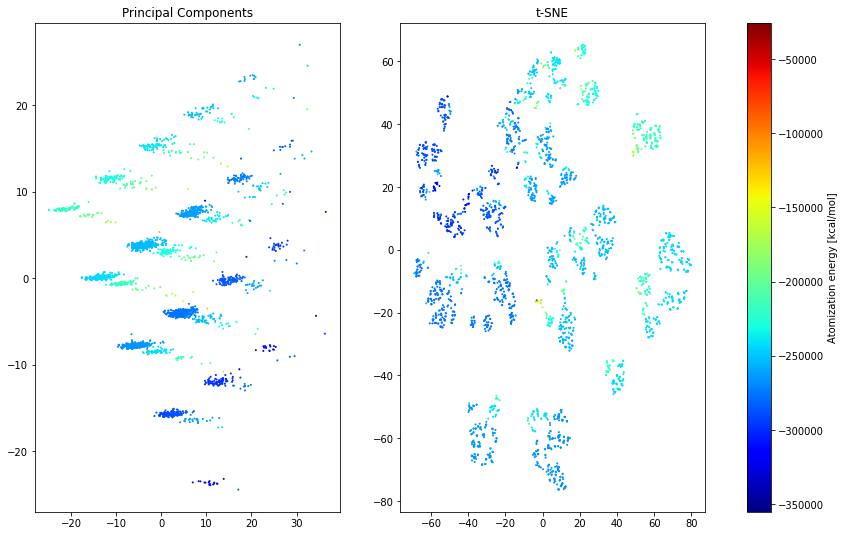

In [102]:
fig, axs = plt.subplots(1,2,figsize=(15,9))
axs[0].set_title('Principal Components')
axs[1].set_title('t-SNE')

plot1 = axs[0].scatter(pca_data[:, 0], pca_data[:, 1], c=target, cmap='jet', s=1)
plot2 = axs[1].scatter(tsne_data[:, 0], tsne_data[:, 1], c=target, cmap='jet', s=1)

cbar = fig.colorbar(plot2, ax=axs);
cbar.set_label('Atomization energy [kcal/mol]')
plt.show()

## Regression with molecular kernels

In the previous parts, we selected target data and prepared three different representations. We can now use them to define kernels and find $\alpha$ coefficinets for the rgeression. We need to solve the equation

$\alpha = (\mathbf{K} + \lambda\mathbf{I} ) ^{-1} \mathbf{y} $.

To do so, we will use Cholesky decomposition which is implemented in qml. 


### The Coulomb matrix

Firstly, we split cm representation and the target properties into train and test sets. Then, we define the kernel and use it to find the $\alpha$ coefficient. As a last step we use the coefficients to predict target values for the test set.

In [22]:
#Let's split the data in training set and test set as in the previous notebooks
from sklearn.model_selection import train_test_split
X_cm_train, X_cm_test, Y_cm_train, Y_cm_test = train_test_split(cm, target, test_size=0.2, random_state=42)

In [23]:
sigmas = np.arange(100,5000,500)
test_maes = []

# We first compute the pariwise distances between cm representations to speed up the
# computation of multiple kernels with different sigma
dm_train_train = sklearn.metrics.pairwise_distances(X_cm_train, X_cm_train, n_jobs=-1)
dm_train_test = sklearn.metrics.pairwise_distances(X_cm_train, X_cm_test, n_jobs=-1)

for sigma in sigmas:
    K_cm = np.exp( - dm_train_train ** 2 / (2 * sigma ** 2))

    # Add a small lambda to the diagonal of the kernel matrix
    K_cm[np.diag_indices_from(K_cm)] += 1e-8

    # Use the built-in Cholesky-decomposition to solve
    alpha_cm = cho_solve(K_cm, Y_cm_train)

    # calculate a kernel matrix between test and training data, using the same sigma
    K_cm_test = np.exp( - dm_train_test ** 2 / (2 * sigma ** 2))

    # Make the predictions
    Y_cm_predicted = np.dot(K_cm_test.T, alpha_cm)

    # Calculate mean-absolute-error (MAE), the units are Hartree
    test_MAE = np.mean(np.abs(Y_cm_predicted - Y_cm_test))
    test_maes.append(test_MAE)

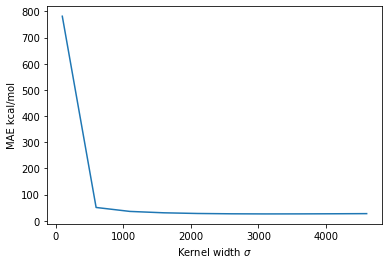

In [24]:
fig, ax = plt.subplots()

ax.plot(sigmas, test_maes)
ax.set_ylabel('MAE kcal/mol')
ax.set_xlabel('Kernel width $\sigma$')
# ax.set_ylim([0,30])
plt.show()


In [25]:
best_sigma = sigmas[np.argmin(test_maes)]

In [26]:
print('Best sigma:', best_sigma)

Best sigma: 3100


In [27]:
#Now we create kernel using selected training data
# Define the kernel width
sigma = best_sigma

# K is also a Numpy array
K_cm = gaussian_kernel(X_cm_train, X_cm_train, sigma)

In [28]:

# Add a small lambda to the diagonal of the kernel matrix
K_cm[np.diag_indices_from(K_cm)] += 1e-8

# Use the built-in Cholesky-decomposition to solve
alpha_cm = cho_solve(K_cm, Y_cm_train)

print(alpha_cm)

[-1.72214025e+09 -1.37779221e+09 -6.40402006e+08 ...  2.42741968e+09  5.94869282e+08
 -1.19747799e+09]


In [29]:
# calculate a kernel matrix between test and training data, using the same sigma
K_cm_test = gaussian_kernel(X_cm_test, X_cm_train, sigma)

# Make the predictions
Y_cm_predicted = np.dot(K_cm_test, alpha_cm)

# Calculate mean-absolute-error (MAE), the units are Hartree
print('MAE: ', np.mean(np.abs(Y_cm_predicted - Y_cm_test)), 'kcal/mol')

MAE:  25.9089601944067 kcal/mol


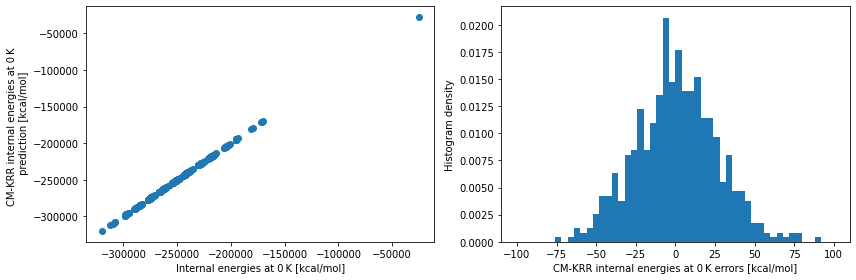

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=[12,4])
ax = axes[0]
ax.scatter(Y_cm_test, Y_cm_predicted)
ax.set_ylabel('CM-KRR internal energies at 0 K \n prediction [kcal/mol]')
ax.set_xlabel('Internal energies at 0 K [kcal/mol]')

ax = axes[1]
ax.hist(Y_cm_test - Y_cm_predicted, bins=50, range=[-100,100], density=True)
ax.set_ylabel('Histogram density')
ax.set_xlabel('CM-KRR internal energies at 0 K errors [kcal/mol]')
plt.tight_layout()
plt.show()

### SLATM

We skip BoB as fundamentally is not very different than the Coulomb Matrix. Let's try the same exercise with SLATM:

In [31]:
#Let's split the data in training set and test set as in the previous notebooks
from sklearn.model_selection import train_test_split
X_slatm_train, X_slatm_test, Y_slatm_train, Y_slatm_test = train_test_split(
    slatm, target, test_size=0.2, random_state=42)

In [32]:
sigmas = np.arange(100,5000,500)
test_maes = []

# Here we first compute the pariwise distances between SLATM representations to speed up the
# computation of multiple kernels with different sigma
dm_train_train = sklearn.metrics.pairwise_distances(X_slatm_train, X_slatm_train, n_jobs=-1)
dm_train_test = sklearn.metrics.pairwise_distances(X_slatm_train, X_slatm_test, n_jobs=-1)

for sigma in sigmas:
    K_slatm = np.exp( - dm_train_train ** 2 / (2 * sigma ** 2))

    # Add a small lambda to the diagonal of the kernel matrix
    K_slatm[np.diag_indices_from(K_slatm)] += 1e-8

    # Use the built-in Cholesky-decomposition to solve
    alpha_slatm = cho_solve(K_slatm, Y_slatm_train)

    # calculate a kernel matrix between test and training data, using the same sigma
    K_slatm_test = np.exp( - dm_train_test ** 2 / (2 * sigma ** 2))

    # Make the predictions
    Y_slatm_predicted = np.dot(K_slatm_test.T, alpha_slatm)

    # Calculate mean-absolute-error (MAE), the units are Hartree
    test_MAE = np.mean(np.abs(Y_slatm_predicted - Y_slatm_test))
    test_maes.append(test_MAE)

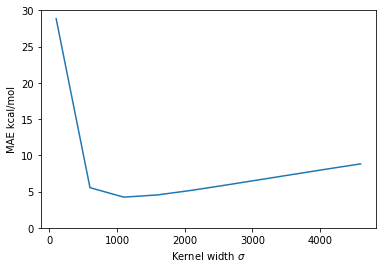

In [33]:
fig, ax = plt.subplots()

ax.plot(sigmas, test_maes)
ax.set_ylabel('MAE kcal/mol')
ax.set_xlabel('Kernel width $\sigma$')
ax.set_ylim([0,30])
plt.show()

In [34]:
best_sigma = sigmas[np.argmin(test_maes)]

In [35]:
print('Best sigma:', best_sigma)

Best sigma: 1100


In [36]:
#Now we create kernel using selected training data
# Define the kernel width
sigma = 1000.0

# K is also a Numpy array
K_slatm = np.exp( - dm_train_train ** 2 / (2 * sigma ** 2))

In [37]:
# Add a small lambda to the diagonal of the kernel matrix
K_slatm[np.diag_indices_from(K_slatm)] += 1e-8

# Use the built-in Cholesky-decomposition to solve
alpha_slatm = cho_solve(K_slatm, Y_slatm_train)

print(alpha_slatm)

[-7.28006365e+07 -4.29888277e+08  8.09026572e+05 ...  1.71880946e+08 -1.71831926e+08
 -8.54710851e+07]


In [38]:
# calculate a kernel matrix between test and training data, using the same sigma
K_slatm_test = np.exp( - dm_train_test ** 2 / (2 * sigma ** 2))

# Make the predictions
Y_slatm_predicted = np.dot(K_slatm_test.T, alpha_slatm)

# Calculate mean-absolute-error (MAE), the units are Hartree
print('MAE: ', np.mean(np.abs(Y_slatm_predicted - Y_slatm_test)), 'kcal/mol')

MAE:  4.279472345794608 kcal/mol


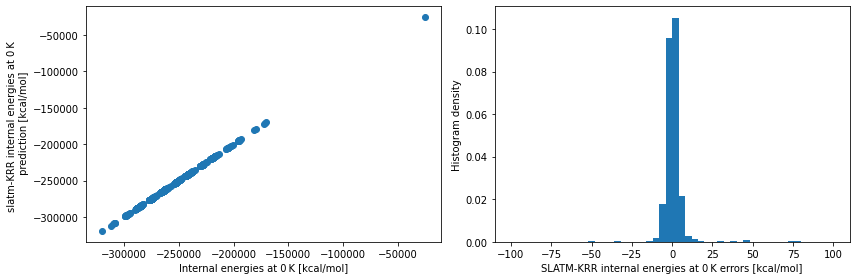

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=[12,4])
ax = axes[0]
ax.scatter(Y_slatm_test, Y_slatm_predicted)
ax.set_ylabel('slatm-KRR internal energies at 0 K \n prediction [kcal/mol]')
ax.set_xlabel('Internal energies at 0 K [kcal/mol]')

ax = axes[1]
ax.hist(Y_slatm_test - Y_slatm_predicted, bins=50, range=[-100,100], density=True)
ax.set_ylabel('Histogram density')
ax.set_xlabel('SLATM-KRR internal energies at 0 K errors [kcal/mol]')
plt.tight_layout()
plt.show()

Let's compare the errors performed with the CM vs SLATM

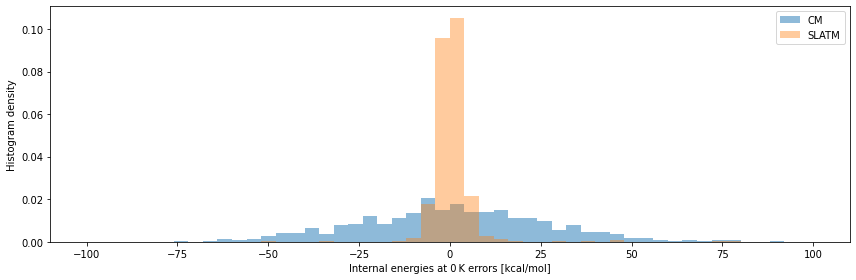

In [40]:
fig, ax = plt.subplots(figsize=[12,4])
ax
ax.hist(Y_cm_test - Y_cm_predicted, bins=50, range=[-100,100], 
        density=True, label='CM', alpha=0.5)
ax.hist(Y_slatm_test - Y_slatm_predicted, bins=50, range=[-100,100], 
        density=True, label='SLATM', alpha=0.4)
ax.set_ylabel('Histogram density')
ax.set_xlabel('Internal energies at 0 K errors [kcal/mol]')
ax.legend()
plt.tight_layout()
plt.show()

We see that SLATM is widely superior to the CM matrix.

# Bonus: Exploring atomic environments with atomic SLATM

The SLATM representation has two formats, the local and the global. The global mode is the one we have used before, and generates a unique vector for a molecular system. The local SLATM generates a vector of the same size for each atom in the system, which captures the local environment of each atom. The global SLATM is actually the addition of all the local vectors.

A local representation has many uses that are beyond the scope of this tutorial, for example scalable atomistic potential energy models. Here we will use it for a quick example to study the different local environments of Carbon in a subset of the qm9 data we used in the previous section.

In [48]:
local_carbon_slatm = []
mbtypes = get_slatm_mbtypes(atomic_numbers_list)
for structure in ase_mols[:500]: # Runs for loop over every molecule in the database
    atomic_numbers = structure.get_atomic_numbers() # ASE prints atomic numbers
    coordinates = structure.get_positions() #ASE prints coordinates
    local_slatm1 = generate_slatm(coordinates,atomic_numbers,mbtypes, local=True)
    carbons = [loc_slatm for at, loc_slatm in zip(
        atomic_numbers, local_slatm1) if at==6]
    local_carbon_slatm.append(carbons) # All CM representations are added into one variable

In [49]:
local_carbon_slatm = np.vstack(local_carbon_slatm)

In [51]:
# We have 2818 carbon environments
local_carbon_slatm.shape

(2818, 11960)

We can use PCA and t-SNE to visualize the carbon environments

In [54]:
from sklearn import manifold


In [55]:
tsne = sklearn.manifold.TSNE(n_components=2)
tsne_data = tsne.fit_transform(local_carbon_slatm)

In [57]:
pca = sklearn.decomposition.PCA(n_components=2)
pca_data = pca.fit_transform(local_carbon_slatm)

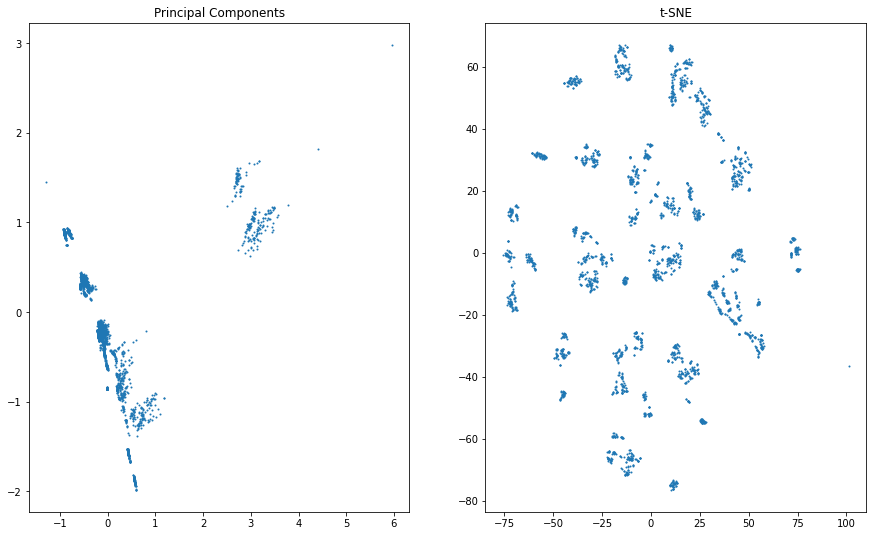

In [88]:
fig, axs = plt.subplots(1,2,figsize=(15,9))
axs[0].set_title('Principal Components')
axs[1].set_title('t-SNE')

plot1 = axs[0].scatter(pca_data[:, 0], pca_data[:, 1], s=1)
plot2 = axs[1].scatter(tsne_data[:, 0], tsne_data[:, 1], s=1)

plt.show()

We can color code this map with different properties to rationalize the different clusters. For example, the minimum distance to another atom.

In [89]:
closest_atom_distance = []

for mol in ase_mols[:500]:
    carbon_indices = np.where(np.array(mol.get_chemical_symbols()) == 'C')[0]
    dm = sklearn.metrics.pairwise_distances(mol.positions, mol.positions)
    dm += np.eye(dm.shape[0]) * 10
    closest = dm.min(axis=0)
    closest = closest[carbon_indices]
    closest_atom_distance.append(closest)

In [90]:
closest_atom_distance = np.concatenate(closest_atom_distance)

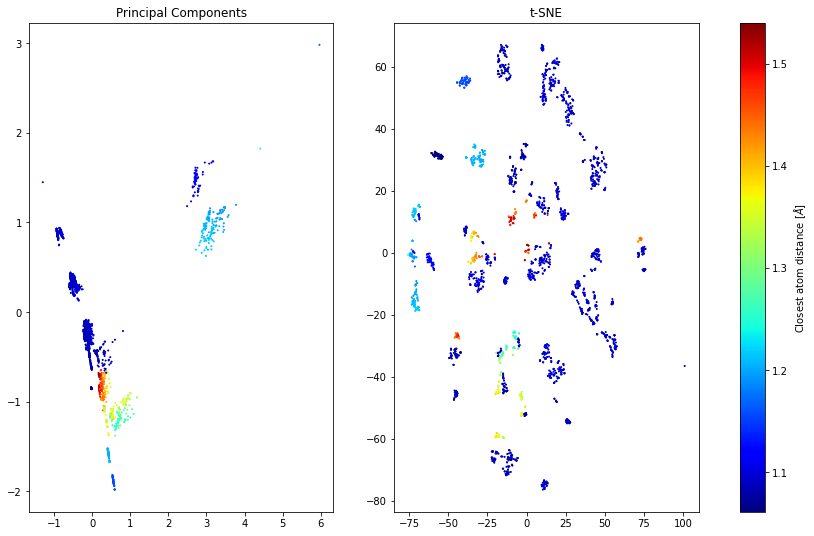

In [91]:
fig, axs = plt.subplots(1,2,figsize=(15,9))
axs[0].set_title('Principal Components')
axs[1].set_title('t-SNE')

plot1 = axs[0].scatter(pca_data[:, 0], pca_data[:, 1], c=closest_atom_distance, cmap='jet', s=1)
plot2 = axs[1].scatter(tsne_data[:, 0], tsne_data[:, 1], c=closest_atom_distance, cmap='jet', s=1)

cbar = fig.colorbar(plot2, ax=axs);
cbar.set_label('Closest atom distance [$\AA$]')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9c5b533d-8121-454d-9fa0-cbfc9a47c2e1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>